# Import needed libraries

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
import os
from skimage import io, exposure ,color #Convert the image to grayscale using `color.rgb2gray`
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, log_loss
from sklearn.preprocessing import LabelEncoder
import cv2 # : Imports OpenCV for image processing tasks.
import seaborn as sns  # Import seaborn for better visualization
from sklearn.utils import shuffle
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler



# extract hog features

In [25]:
def extract_hog_features(img):
    
    gry_image = color.rgb2gray(img)
    
    hog_feature, hog_img = hog(gry_image,visualize=True)
    
    hog_img_rescaled = exposure.rescale_intensity(hog_img, in_range=(0,10)) # for better visualization
    
    return hog_feature , hog_img_rescaled

# Plt roc curve multi-class

In [26]:
def plot_roc_curve_multi_class(y_true, y_score, classes):
    plt.figure(figsize=(8, 6))
    
    for i in range(len(classes)):
        # Roc cruve and AUC for each class
        fpr, tpr, _ = roc_curve(y_true==i,y_score[:,i])
        roc_auc = auc(fpr,tpr)
        
        plt.plot(fpr,tpr,label=f'ROC curve for class {classes[i]} (area = {roc_auc:.3f})')
    
    plt.plot([0, 1], [0, 1], '--')  # random guessing
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05]) #0.5 for better vision of the curve 
    plt.xlabel('False Positive Rate\n    1-specificity     ')
    plt.ylabel('True Positive Rate\n    sensitivity    ')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()   

# plot confusion matrix

In [27]:
def plot_confusion_matrix(y_true,y_pred,classes):
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,8))
    sns.heatmap(cm, annot=True, cmap='Greys', fmt='g', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

# plot loss curve on training and testing data

In [28]:
def plot_loss_curve_on_training_and_testing_data(model, X_train, y_train, X_test, y_test):
    
    train_loss_values = []
    test_loss_values = []
    
    # initial loss of the training
    y_train_prob = model.predict_proba(X_train)
    train_initial_loss = log_loss(y_train,y_train_prob)
    train_loss_values.append(train_initial_loss)
    
    # initial loss of the test
    y_test_prob = model.predict_proba(X_test)
    test_initial_loss = log_loss(y_train,y_train_prob)
    test_loss_values.append(test_initial_loss)
    
    for i in range(1,101):
        
        model.partial_fit(X_train,y_train)
        # support incremental learning (like SGDClassifier), which allows them to be trained on small batches of data. Instead of retraining from scratch
        
        # loss of the training
        y_train_prob = model.predict_proba(X_train)
        train_initial_loss = log_loss(y_train,y_train_prob)
        train_loss_values.append(train_initial_loss)
        
        # loss of the test
        y_test_prob = model.predict_proba(X_test)
        test_initial_loss = log_loss(y_train,y_train_prob)
        test_loss_values.append(test_initial_loss)
        
        
    # loss curves
    plt.figure(figsize=(8, 6))
    plt.plot(range(0, 101), train_loss_values, label='Training Loss Curve', color='blue')
    plt.plot(range(0, 101), test_loss_values, label='Testing Loss Curve', color='red')
    plt.xlabel('Iteration')
    plt.ylabel('Log Loss')
    plt.title('Loss Curves on Training and Testing Data')
    plt.legend()
    plt.show()

In [29]:
dataset_path = 'D:\\collage\\third year\\first semester\\Machine learning\\Project\\dataset\\archive\\cell_images\\cell_images'

In [30]:
class_folders = [f.path for f in os.scandir(dataset_path) if f.is_dir()]
features_list = []
labels_list = []

image with fearure extraction from the class Parasitized


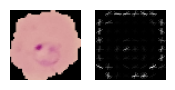

image with fearure extraction from the class Uninfected


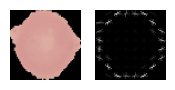

In [31]:
# List all subdirectories -each subdirectory corresponds to a class-
class_folders = [f.path for f in os.scandir(dataset_path) if f.is_dir()]
features_list = []
labels_list = []

# Loop through each class folder
for class_folder in class_folders:
    class_name = os.path.basename(class_folder)

    # Collect all image filenames
    image_filenames = os.listdir(class_folder)

    # Loop through each image in the class folder
    for i,image_filename in enumerate(image_filenames):
        
        image_path = os.path.join(class_folder, image_filename)

        # Load the image
        image = io.imread(image_path)

        # Resize the image to 64x64
        resized_image = cv2.resize(image, (64, 64))

        # Extract HOG features and visualize
        hog_features, hog_image = extract_hog_features(resized_image)
        
        if(i==0):
            
            print(f"image with fearure extraction from the class {class_name}")
            
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(2, 2), sharex=True, sharey=True)

            ax1.axis('off')
            ax1.imshow(resized_image, cmap=plt.cm.gray)

            ax2.axis('off')
            ax2.imshow(hog_image, cmap=plt.cm.gray)

            plt.show()
        
        features_list.append(hog_features)

        labels_list.append(class_name)

In [32]:
# Convert lists to NumPy arrays
features_array = np.array(features_list)
labels_array = np.array(labels_list)

In [33]:
# Use LabelEncoder to convert class names into numeric labels
label_encoder = LabelEncoder()
numeric_labels = label_encoder.fit_transform(labels_array)

In [34]:
# Shuffle the data
features_array, numeric_labels = shuffle(features_array, numeric_labels, random_state=54)features_array, numeric_labels = shuffle(features_array, numeric_labels, random_state=54)

In [40]:
#pipeline
alpha_value = 0.01  # Adjust this value as needed
model_pipeline = make_pipeline(
    StandardScaler(), 
    SGDClassifier(loss='log_loss', alpha=alpha_value, max_iter=1000, random_state=42)
)

In [41]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_array, numeric_labels, test_size=0.2, random_state=42)

In [42]:
# Fit the model on the training data using the pipeline (with scaling)
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdclassifier',
                 SGDClassifier(alpha=0.01, loss='log_loss', random_state=42))])

In [43]:
# Calculate predicted probabilities for each class separately
y_prob_hog = model_pipeline.predict_proba(X_test)

In [44]:
# Make predictions on the test set
y_pred_hog = model_pipeline.predict(X_test)

In [45]:
accuracy_hog = accuracy_score(y_test, y_pred_hog)
print(f"Accuracy for HOG: {accuracy_hog}")

Accuracy for HOG: 0.8613284804367607


In [46]:
print("Classification Report for HOG:")
print(classification_report(y_test, y_pred_hog, target_names=label_encoder.classes_))

Classification Report for HOG:
              precision    recall  f1-score   support

 Parasitized       0.87      0.85      0.86      2796
  Uninfected       0.85      0.87      0.86      2699

    accuracy                           0.86      5495
   macro avg       0.86      0.86      0.86      5495
weighted avg       0.86      0.86      0.86      5495



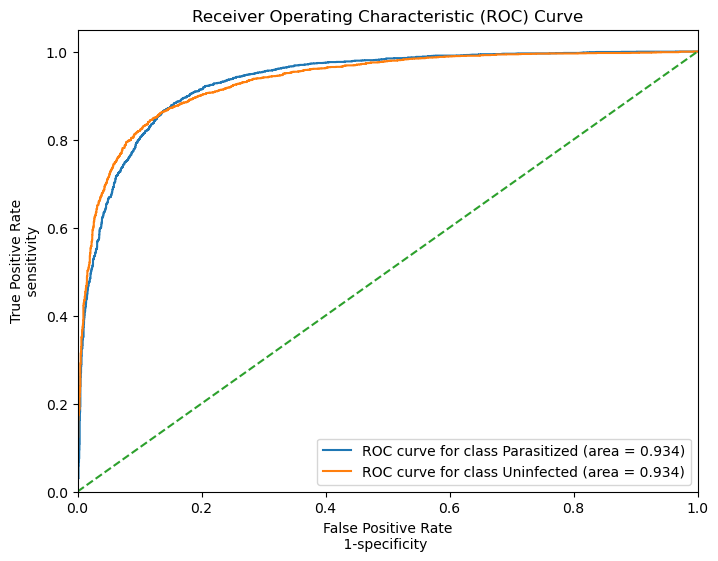

In [47]:
plot_roc_curve_multi_class(y_test, y_prob_hog, classes=label_encoder.classes_)

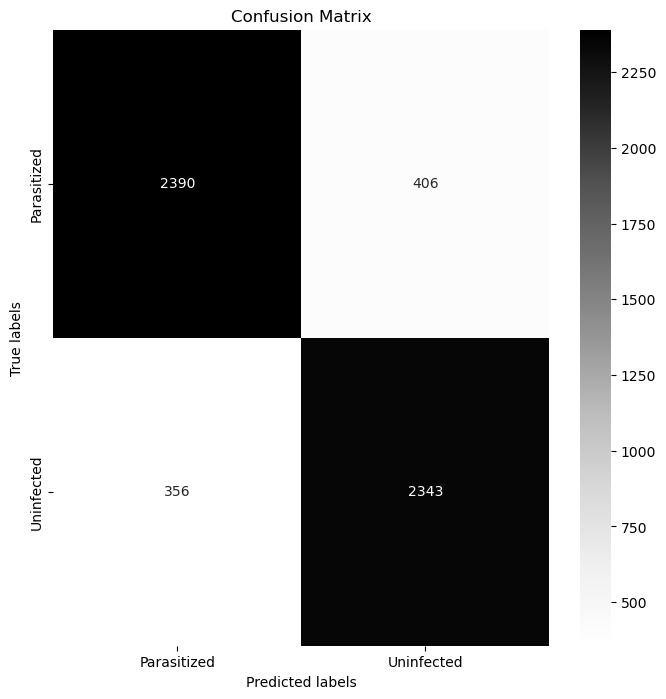

In [48]:
plot_confusion_matrix(y_test, y_pred_hog, classes=label_encoder.classes_)

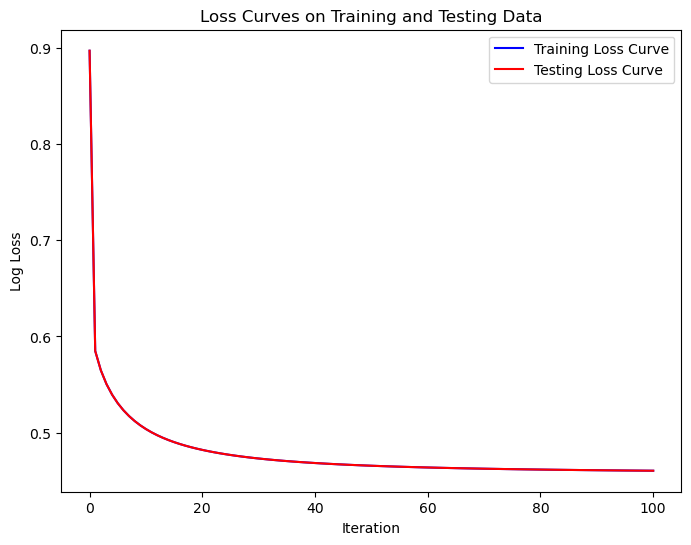

In [49]:
plot_loss_curve_on_training_and_testing_data(model_pipeline.named_steps['sgdclassifier'], X_train, y_train, X_test, y_test)

# Saving The Model

In [ ]:
import joblib
from sklearn.preprocessing import LabelEncoder

# Example code to save the model and class labels
model_filename = 'hog_sgd_classifier_model.pkl'
labels_filename = 'class_labels.pkl'

# Save the trained model
joblib.dump(model_pipeline, model_filename)

# Save the class labels
class_labels = ['Parasitized', 'Uninfected']  # Replace with actual class labels

label_encoder = LabelEncoder()
label_encoder.fit(class_labels)

# Save the label encoder
joblib.dump(label_encoder, 'class_labels.pkl')

# GUI for prediction

In [74]:
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk
import numpy as np
from skimage.feature import hog
from skimage import color, exposure
import joblib

# Load the trained model and label encoder
model_filename = 'hog_sgd_classifier_model.pkl'
labels_filename = 'class_labels.pkl'

model_pipeline = joblib.load(model_filename)
label_encoder = joblib.load(labels_filename)  # Load the label encoder with class labels

def extract_hog_features(img):
    gray_image = color.rgb2gray(img)
    hog_features, hog_image = hog(gray_image, visualize=True)
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
    return hog_features, hog_image_rescaled

def predict_image(image_path):
    image = Image.open(image_path)
    image = image.resize((64, 64))
    image_array = np.array(image)

    hog_features, _ = extract_hog_features(image_array)
    hog_features = hog_features.reshape(1, -1)  # Reshape for the model

    prediction = model_pipeline.predict(hog_features)
    return prediction

def upload_image():
    file_path = filedialog.askopenfilename(filetypes=[("Image files", "*.jpg;*.jpeg;*.png")])
    if file_path:
        image = Image.open(file_path)
        image = image.resize((250, 250))  # Resize image to fit in the window
        img = ImageTk.PhotoImage(image)
        panel.configure(image=img)
        panel.image = img
        
        # Predict the result
        result = predict_image(file_path)
        class_name = label_encoder.classes_[result[0]]
        result_label.config(text=f"Predicted Class: {class_name}")

# Initialize the Tkinter GUI
root = tk.Tk()
root.title("Image Classification")

# Set the window size and position to make it larger and center it on the screen
window_width = 600
window_height = 600
screen_width = root.winfo_screenwidth()
screen_height = root.winfo_screenheight()
x_position = (screen_width // 2) - (window_width // 2)
y_position = (screen_height // 2) - (window_height // 2)
root.geometry(f'{window_width}x{window_height}+{x_position}+{y_position}')

# Create a frame for the image and result to keep them organized
frame = tk.Frame(root)
frame.pack(expand=True, fill=tk.BOTH, padx=20, pady=20)

# Create a button to upload the image
upload_btn = tk.Button(frame, text="Upload Image", command=upload_image, font=("Helvetica", 16))
upload_btn.pack(pady=10)

# Create a label to display the uploaded image
panel = tk.Label(frame)
panel.pack(pady=10)

# Create a label to display the prediction result
result_label = tk.Label(frame, text="", font=("Helvetica", 24))
result_label.pack(pady=10)

# Start the Tkinter event loop
root.mainloop()
